In [1]:
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import random
import os
import pathlib
import shutil
from scipy import stats
import sys
import warnings
import math
import numpy as np
import cv2
import pyqtgraph as pg
from PyQt5 import QtGui, QtCore
from skimage.metrics import structural_similarity as ssim
import sys
import SimpleITK as sitk
import time
from PyQt5.QtGui import QIcon, QPainter, QColor
from PyQt5 import QtWidgets, uic
from PyQt5.QtWidgets import QWidget, QMainWindow,QPushButton, QApplication, QComboBox, QLabel, QLineEdit, QMessageBox,QHBoxLayout, QVBoxLayout
from PyQt5.QtCore import QCoreApplication, QTimer
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import random
from matplotlib.colors import hsv_to_rgb
import datajoint as dj
dj.config["enable_python_native_blobs"] = True
dj.config['database.host'] = '128.178.198.9'
dj.config['database.host'] = 'datajoint.epfl.ch'
dj.config['database.user'] = 'foustouk'
dj.config['database.password'] = '+syVVWMGf7.-'
ConnMessage=dj.conn()
%cd ..
from lsensdatajoint.pipeline import lsensGF
all_schemas=dj.list_schemas()

[2023-11-09 14:54:31,678][INFO]: Connecting foustouk@datajoint.epfl.ch:3306
[2023-11-09 14:54:31,706][INFO]: Connected foustouk@datajoint.epfl.ch:3306


h:\Datajoint\lsens_datajoint_pipeline_0


In [2]:
class ProjectionsGUI(QMainWindow):
    
    def __init__(self):
        super(ProjectionsGUI, self).__init__()
        pg.setConfigOptions(imageAxisOrder="row-major")

        self.setWindowTitle("Pick projection neurons depending on dual CTB-injections")

        self.setGeometry(50, 50, 2100, 1100)

        self.home()
        
    def home(self):
        
        pg.setConfigOption('background', 'w')
        pg.setConfigOption('foreground', 'k')
        
        # self.serverDir = os.path.join(r"\\sv2files", "Petersen-Lab","analysis","Georgios_Foustoukos","ProjectionsRois")
        self.serverDir = os.path.join(r"\\sv-nas1.rcp.epfl.ch", "Petersen-Lab","analysis","Anthony_Renard","ProjectionsRois")
        
        cwidget = QtWidgets.QWidget()
        self.l0 =  QtWidgets.QHBoxLayout()
        self.buttons =  QtWidgets.QVBoxLayout()
        
        cwidget.setLayout(self.l0)
        self.setCentralWidget(cwidget)
        
        self.maxprojWin =pg.GraphicsLayoutWidget()
        self.redWin = pg.GraphicsLayoutWidget()
        self.farRedWin =  pg.GraphicsLayoutWidget()
        
        self.maxproj = pg.ImageItem(name='ROIs')
        self.red = pg.ImageItem(name='Red')
        self.farRed = pg.ImageItem(name='FarRed')
        
        self.l0.addLayout(self.buttons)
        self.l0.addWidget(self.maxprojWin)
        self.l0.addWidget(self.redWin)
        self.l0.addWidget(self.farRedWin)
        
        self.labelMouseName = QLabel(self)
        self.labelMouseName.setText('Choose mouse name:')
        self.labelMouseName.adjustSize()
        
        self.comboBoxMouseName = QComboBox(self)
        self.comboBoxMouseName.addItem('')
        mouseList = lsensGF.ProjectionsInfo().fetch('mouse_name')
        mouseListUnique = list(dict.fromkeys(mouseList))
        self.comboBoxMouseName.addItems(mouseListUnique)
        self.comboBoxMouseName.activated.connect(self.load_mousename)
        
        self.RButton = QtWidgets.QPushButton("Red")
        self.RButton.clicked.connect(self.clickedRedButton)
        
        self.FRButton = QtWidgets.QPushButton("FarRed")
        self.FRButton.clicked.connect(self.clickedFarRedButton)
        
        self.UNButton = QtWidgets.QPushButton("UN")
        self.UNButton.clicked.connect(self.clickedUNButton)
        
        self.CloseButton = QtWidgets.QPushButton("Close")
        self.CloseButton.clicked.connect(self.close_application_immediately)
        
        self.labelRatio = QLabel(self)
        self.labelRatio.setText('Ratio FR/R = ')
        
        self.labelSsiGR = QLabel(self)
        self.labelSsiGR.setText('SSI G vs R = ')
        
        self.labelSsiRFR = QLabel(self)
        self.labelSsiRFR.setText('SSI R vs FR = ')
        
        self.buttons.addWidget(self.labelMouseName)
        self.buttons.addWidget(self.comboBoxMouseName )
        self.buttons.addWidget(self.RButton)
        self.buttons.addWidget(self.FRButton)
        self.buttons.addWidget(self.UNButton)
        self.buttons.addWidget(self.labelRatio)
        self.buttons.addWidget(self.labelSsiGR)
        self.buttons.addWidget(self.labelSsiRFR)
        
        self.buttons.addStretch(1)
        
        self.buttons.addWidget(self.CloseButton)
        
        self.show()
        
    def close_application_immediately(self):
        
        #exit application immediately
        QApplication.quit()
               
        
    def load_mousename(self):
        
        choiceMouse= (str(self.comboBoxMouseName.currentText()))
        
        if choiceMouse == '':
            self.sessionkey = {}

        else:
            self.sessionkey = {}
            self.sessionkey['mouse_name'] = choiceMouse
            print(self.sessionkey)
            
            self.serverDir = pathlib.Path(os.path.join(self.serverDir, choiceMouse))
            
            if not(self.serverDir.is_dir()):
                print('Folder made!')
                os.makedirs(self.serverDir)
                
            self.load_images()
            
    def load_images(self):
        
        (self.ImgRed, self.ImgFarRed, self.ImgGreen,
         self.ImgRedFull,self.ImgFarRedFull, self.ImgGreenFull) = self.registerImages()
        
        self.calculateRatiosROIs()
        
        #check if files already exist
        
        self.CheckRedFile =  pathlib.Path(os.path.join(self.serverDir, "RedRois.npy"))
        self.CheckFarRedFile =  pathlib.Path(os.path.join(self.serverDir, "FarRedRois.npy"))
        self.CheckUNFile =  pathlib.Path(os.path.join(self.serverDir, "UNRois.npy"))
        
        if not(self.CheckRedFile.is_file()) or not(self.CheckFarRedFile.is_file()) or not(self.CheckUNFile.is_file()):
            
            (self.FarRed, self.Red, self.UN) =  self.predefineRois() 
            
        if self.CheckRedFile.is_file():
            
            self.Red = np.load(self.CheckRedFile ,allow_pickle=True)
            
        if self.CheckFarRedFile.is_file():
            
            self.FarRed = np.load(self.CheckFarRedFile ,allow_pickle=True)
            
        if self.CheckUNFile.is_file():
            
            self.UN = np.load(self.CheckUNFile,allow_pickle=True)
        
        (self.ROIsImage, self.iROIs, self.maximg,o
         self.H, self.S, self.xrange, self.yrange, self.Lx, self.Ly) = self.makeRoisImage()
        
        self.plot0 = pg.PlotItem(name='Cells',title = 'ROIs Image')
        self.plot1 = pg.PlotItem(name='Red', title = 'Red Image')
        self.plot2= pg.PlotItem(name='FarRedImage', title = 'FarRed Image')
        
        self.plot0.setAspectLocked()
        self.plot0.hideAxis('bottom')
        self.plot0.hideAxis('left')

        self.plot1.setAspectLocked()
        self.plot1.hideAxis('bottom')
        self.plot1.hideAxis('left')

        self.plot2.setAspectLocked()
        self.plot2.hideAxis('bottom')
        self.plot2.hideAxis('left')
        
        self.maxprojWin.addItem(self.plot0, 0,0)
        self.plot0.addItem(self.maxproj)
        self.maxproj.setImage(self.ROIsImage)
                        
        self.redWin.addItem(self.plot1, 0,0)
        self.plot1.addItem(self.red)
        self.red.setImage(self.ImgRed)
        
        self.farRedWin.addItem(self.plot2, 0,0)
        self.plot2.addItem(self.farRed)
        self.farRed.setImage(self.ImgFarRed)
        
        #if the mouse is clicked proceed with roi selection
        self.plot0.scene().sigMouseClicked.connect(self.mouseClickedGreen)
        
        #if the mouse is clicked proceed with roi selection
        self.plot1.scene().sigMouseClicked.connect(self.mouseClickedRed)
              
        #if the mouse is clicked proceed with roi selection
        self.plot2.scene().sigMouseClicked.connect(self.mouseClickedFarRed)
        
        self.show()
        
        
    def ROIindex(self):
        
        #find the index of the clicked ROI

        #check if the clicked point is out of borders and if not select it

        posNeg = (self.x < 0) or (self.y < 0)
        posOut = (self.x >= self.ROIsImage.shape[0]) or (self.y >= self.ROIsImage.shape[1])
        if posNeg or posOut:
            pass
            roiSelected = -1
        else:
            print('x: ' + str(self.x))
            print('y: ' + str(self.y))
            roiSelected = int(self.iROIs[self.x,self.y])
            print('ROI selected: ' + str(roiSelected))

        return roiSelected
    
    def circle(self,med,r):
        
        """ returns pixels of circle with radius 2x radius of cell (r) """
        theta = np.linspace(0.0,2*np.pi,100)
        x = r*2 * np.cos(theta) + med[0]
        y = r*2 * np.sin(theta) + med[1]
        x = x.astype(np.int32)
        y = y.astype(np.int32)
        
        return x,y


    def newROIimage(self):
        
        titleNew =  'ROIs Image, ' + 'ROI selected: ' + str(int(self.roiSelected))

        self.plot0.setTitle(titleNew)

        self.sessionkey.update({'roi_number': self.roiSelected})
        
        print(self.sessionkey)
        
        stats = (lsensGF.CalciumRois & self.sessionkey).fetch('roi_stats')
        
        stats = stats[0]

        #add a white color to the selected ROI
        roix = stats['xpix'].flatten()

        roiy = stats['ypix'].flatten()
        
        #make new green ROIs image

        HN = np.copy(self.H)
        SN = np.copy(self.S)
        VN = np.copy(self.maximg)

        HN[roix, roiy] = 0
        SN[roix, roiy] = 0
        VN[roix, roiy] = 1
             
        center = [int(np.round(np.abs(np.max(roix)-np.min(roix))/2 + np.min(roix))),
                  int(np.round(np.abs(np.max(roiy)-np.min(roiy))/2 + np.min(roiy)))]
        
        r = int(stats['radius'])
        
        (self.xc,self.yc) = self.circle(center,r)
        
        HN[self.xc, self.yc] = 0
        SN[self.xc, self.yc] = 1
        VN[self.xc, self.yc] = 1    

        pixN = np.concatenate(((HN[:, :, np.newaxis]),
                                  SN[:, :, np.newaxis],
                                  VN[:, :, np.newaxis]), axis=-1)
        pixN = hsv_to_rgb(pixN)

        ROIsImageN = pixN[self.xrange[0]:self.xrange[1],self.yrange[0]:self.yrange[1],:]
        
        #make red new image with circle
        
        RedImage = np.copy(self.ImgRedFull)
        
        HRN = np.zeros([self.Lx,self.Ly])
        SRN = np.zeros([self.Lx,self.Ly])
        VRN = self.imageNorm(RedImage)
        
                
        HRN[self.xc, self.yc] = 0
        SRN[self.xc, self.yc] = 1
        VRN[self.xc, self.yc] = 1 
        
        pixRN = np.concatenate(((HRN[:, :, np.newaxis]),
                                  SRN[:, :, np.newaxis],
                                  VRN[:, :, np.newaxis]), axis=-1)
        pixRN = hsv_to_rgb(pixRN)
        
        RedN = pixRN[self.xrange[0]:self.xrange[1],self.yrange[0]:self.yrange[1],:]
        
        #make far red new image with circle
        
        FarRedImage = np.copy(self.ImgFarRedFull)
        
        HFRN = np.zeros([self.Lx,self.Ly])
        SFRN = np.zeros([self.Lx,self.Ly])
        VFRN = self.imageNorm(FarRedImage)
        
                
        HFRN[self.xc, self.yc] = 0
        SFRN[self.xc, self.yc] = 1
        VFRN[self.xc, self.yc] = 1 
        
        pixFRN = np.concatenate(((HFRN[:, :, np.newaxis]),
                                  SFRN[:, :, np.newaxis],
                                  VFRN[:, :, np.newaxis]), axis=-1)
        pixFRN = hsv_to_rgb(pixFRN)
        
        FarRedN = pixFRN[self.xrange[0]:self.xrange[1],self.yrange[0]:self.yrange[1],:]
        
        plt.imshow(FarRedN)
        
    
        return(ROIsImageN,RedN,FarRedN)
        

        
    def mouseClickedGreen(self,evt):
        
        #get mouse coordinates in relation to image space
        pos = self.maxproj.mapFromScene(evt.scenePos())

        #round to get pixel size
        self.x = int(pos.y())
        self.y = int(pos.x())
        
        #get the index of the selected ROI after clicking
        self.roiSelected = self.ROIindex()
        
        if self.roiSelected != -1:
            
            (self.ROIsImageN, self.RedN, self.FarRedN) = self.newROIimage()
            
            self.maxproj.setImage(self.ROIsImageN)
            self.red.setImage(self.RedN)
            self.farRed.setImage(self.FarRedN)    
            self.labelRatio.setText('Ratio FR/R = ' + str(np.round(self.Ratio[self.roiSelected],3)))
            self.labelSsiGR.setText('SSI G vs R = '+ str(np.round(self.ssiGR[self.roiSelected],3)))
            self.labelSsiRFR.setText('SSI R vs FR = '+ str(np.round(self.ssiRFR[self.roiSelected])))
            
    def clickedRedButton(self):
        
        if "roi_number" in self.sessionkey:
            
            print("ROI is selected and changed to red")

            stats = (lsensGF.CalciumRois & self.sessionkey).fetch('roi_stats')

            stats = stats[0]

            #add a white color to the selected ROI
            roix = stats['xpix'].flatten()

            roiy = stats['ypix'].flatten()

            #make new  ROIs image with changed color
            
            self.H[roix, roiy] = 0
            self.S[roix, roiy] = 1
            self.maximg[roix, roiy] = 1
            
            # make the circle around the new ROI
            
            center = [int(np.round(np.abs(np.max(roix)-np.min(roix))/2 + np.min(roix))),
                  int(np.round(np.abs(np.max(roiy)-np.min(roiy))/2 + np.min(roiy)))]
        
            r = int(stats['radius'])
        
            (xc,yc) = self.circle(center,r)
            
            HTemp = np.copy(self.H)
            STemp= np.copy(self.S)
            VTemp = np.copy(self.maximg)
        
            HTemp[xc, yc] = 0
            STemp[xc, yc] = 1
            VTemp[xc, yc] = 1    

            pixAfterRedClick = np.concatenate(((HTemp[:, :, np.newaxis]),
                                  STemp[:, :, np.newaxis],
                                  VTemp[:, :, np.newaxis]), axis=-1)

            
            pixAfterRedClick  = hsv_to_rgb(pixAfterRedClick)
            
            ROIsImageAfterRedClick = pixAfterRedClick[self.xrange[0]:self.xrange[1],self.yrange[0]:self.yrange[1],:]
            
            self.maxproj.setImage(ROIsImageAfterRedClick)
        
            if self.sessionkey["roi_number"] in self.FarRed:
                
                IndexInFarRed = [i for (i, fr) in enumerate(self.FarRed) if (fr == self.sessionkey["roi_number"]) ]
                self.FarRed = np.delete(self.FarRed, IndexInFarRed[0])
                print(self.FarRed)
                print('Deleted In FarRed at ' + str(IndexInFarRed[0]))
                
            elif self.sessionkey["roi_number"] in self.UN:
                
                IndexInUN = [i for (i, un) in enumerate(self.UN) if (un == self.sessionkey["roi_number"])]
                self.UN = np.delete(self.UN, IndexInUN[0])
                print('Deleted in UN at ' + str(IndexInUN[0]))
                
            # and file to the read and save the file
            
            if not(self.sessionkey["roi_number"] in self.Red) :
                
                self.Red = np.append(self.Red,int(self.sessionkey["roi_number"]))
                
            np.save(self.CheckFarRedFile,self.FarRed)
            np.save(self.CheckRedFile,self.Red)
            np.save(self.CheckUNFile,self.UN)
            
            print('File Saved!')
            
  
    def clickedFarRedButton(self):
        
        if "roi_number" in self.sessionkey:
            
            print("ROI is selected and changed to far red")

            stats = (lsensGF.CalciumRois & self.sessionkey).fetch('roi_stats')

            stats = stats[0]

            #add a white color to the selected ROI
            roix = stats['xpix'].flatten()

            roiy = stats['ypix'].flatten()

            #make new  ROIs image with changed color
            
            self.H[roix, roiy] = 0.67
            self.S[roix, roiy] = 1
            self.maximg[roix, roiy] = 1
            
            # make the circle around the new ROI
            
            center = [int(np.round(np.abs(np.max(roix)-np.min(roix))/2 + np.min(roix))),
                  int(np.round(np.abs(np.max(roiy)-np.min(roiy))/2 + np.min(roiy)))]
        
            r = int(stats['radius'])
        
            (xc,yc) = self.circle(center,r)
            
            HTemp = np.copy(self.H)
            STemp= np.copy(self.S)
            VTemp = np.copy(self.maximg)
        
            HTemp[xc, yc] = 0
            STemp[xc, yc] = 1
            VTemp[xc, yc] = 1    

            pixAfterFarRedClick = np.concatenate(((HTemp[:, :, np.newaxis]),
                                  STemp[:, :, np.newaxis],
                                  VTemp[:, :, np.newaxis]), axis=-1)

            
            pixAfterFarRedClick  = hsv_to_rgb(pixAfterFarRedClick)
            
            ROIsImageAfterFarRedClick = pixAfterFarRedClick[self.xrange[0]:self.xrange[1],self.yrange[0]:self.yrange[1],:]
            
            self.maxproj.setImage(ROIsImageAfterFarRedClick)
            
            
            if self.sessionkey["roi_number"] in self.Red:
                
                IndexInRed = [i for (i, r) in enumerate(self.Red) if (r == self.sessionkey["roi_number"]) ]
                self.Red = np.delete(self.Red, IndexInRed[0])
                print('Deleted In Red at ' + str(IndexInRed[0]))
                
            elif self.sessionkey["roi_number"] in self.UN:
                
                IndexInUN = [i for (i, un) in enumerate(self.UN) if (un == self.sessionkey["roi_number"])]
                self.UN = np.delete(self.UN, IndexInUN[0])
                print('Deleted in UN at ' + str(IndexInUN[0]))
                          
                            
            # and file to the read and save the file
            
            if not(self.sessionkey["roi_number"] in self.FarRed) :
                
                self.FarRed = np.append(self.FarRed,int(self.sessionkey["roi_number"]))
                
            np.save(self.CheckFarRedFile,self.FarRed)
            np.save(self.CheckRedFile,self.Red)
            np.save(self.CheckUNFile,self.UN)
            
            print('File Saved!')
                
                
    def clickedUNButton(self):
        
        if "roi_number" in self.sessionkey:
            
            print("ROI is selected and changed to unidentified")

            stats = (lsensGF.CalciumRois & self.sessionkey).fetch('roi_stats')

            stats = stats[0]

            #add a white color to the selected ROI
            roix = stats['xpix'].flatten()

            roiy = stats['ypix'].flatten()

            #make new  ROIs image with changed color
            
            self.H[roix, roiy] = 0.33
            self.S[roix, roiy] = 1
            self.maximg[roix, roiy] = 1
            
            # make the circle around the new ROI
            
            center = [int(np.round(np.abs(np.max(roix)-np.min(roix))/2 + np.min(roix))),
                  int(np.round(np.abs(np.max(roiy)-np.min(roiy))/2 + np.min(roiy)))]
        
            r = int(stats['radius'])
        
            (xc,yc) = self.circle(center,r)
            
            HTemp = np.copy(self.H)
            STemp= np.copy(self.S)
            VTemp = np.copy(self.maximg)
        
            HTemp[xc, yc] = 0
            STemp[xc, yc] = 1
            VTemp[xc, yc] = 1    

            pixAfterUNClick = np.concatenate(((HTemp[:, :, np.newaxis]),
                                  STemp[:, :, np.newaxis],
                                  VTemp[:, :, np.newaxis]), axis=-1)

            
            pixAfterUNClick  = hsv_to_rgb(pixAfterUNClick)
            
            ROIsImageAfterUNClick = pixAfterUNClick[self.xrange[0]:self.xrange[1],self.yrange[0]:self.yrange[1],:]
            
            self.maxproj.setImage(ROIsImageAfterUNClick)
            
            
            if self.sessionkey["roi_number"] in self.Red:
                
                IndexInRed = [i for (i, r) in enumerate(self.Red) if (r == self.sessionkey["roi_number"]) ]
                self.Red = np.delete(self.Red, IndexInRed[0])
                print('Deleted In Red at ' + str(IndexInRed[0]))
                
            elif self.sessionkey["roi_number"] in self.FarRed:
                
                IndexInFarRed = [i for (i, fr) in enumerate(self.FarRed) if (fr == self.sessionkey["roi_number"])]
                self.FarRed = np.delete(self.FarRed, IndexInFarRed[0])
                print('Deleted in Far Red at ' + str(IndexInFarRed[0]))
                
                
                                        
            # and file to the read and save the file
            
            if not(self.sessionkey["roi_number"] in self.UN) :
                
                self.UN = np.append(self.UN,int(self.sessionkey["roi_number"]))
                
            np.save(self.CheckFarRedFile,self.FarRed)
            np.save(self.CheckRedFile,self.Red)
            np.save(self.CheckUNFile,self.UN)
            
            print('File Saved!')
    
         
    def computeGreenImage(self,x,y):
        
        center = [x,y]
        
        r = 7
        
        (xc,yc) = self.circle(center,r)
                
        HNG = np.copy(self.H[self.xrange[0]:self.xrange[1],self.yrange[0]:self.yrange[1]])
        SNG = np.copy(self.S[self.xrange[0]:self.xrange[1],self.yrange[0]:self.yrange[1]])
        VNG = np.copy(self.maximg[self.xrange[0]:self.xrange[1],self.yrange[0]:self.yrange[1]])
        
                        
        CoordinL = [(xL,yL) for (xL,yL) in zip(xc,yc) if (xL < HNG.shape[0] and yL < HNG.shape[1])]
        
        xf = []
        yf = []
        
        for p in CoordinL:
            
            xf.append(p[0])
            yf.append(p[1])
        
        HNG[xf,yf] = 0
        SNG[xf,yf] = 1
        VNG[xf,yf] = 1 
        
        pixNG = np.concatenate(((HNG[:, :, np.newaxis]),
                                  SNG[:, :, np.newaxis],
                                  VNG[:, :, np.newaxis]), axis=-1)
        pixNG= hsv_to_rgb(pixNG)  
        
        return pixNG
        

            
    def computeRedImage(self,x,y):
         
        center = [x,y]
        
        r = 7
        
        (xc,yc) = self.circle(center,r)
        
        HNR = np.zeros([self.Lx,self.Ly])
        HNR = HNR[self.xrange[0]:self.xrange[1],self.yrange[0]:self.yrange[1]]
        SNR = np.zeros([self.Lx,self.Ly])
        SNR = SNR[self.xrange[0]:self.xrange[1],self.yrange[0]:self.yrange[1]]
        VNR = np.copy(self.ImgRed)
               
        CoordinL = [(xL,yL) for (xL,yL) in zip(xc,yc) if (xL < HNR.shape[0] and yL < HNR.shape[1])]
        
        xf = []
        yf = []
        
        for p in CoordinL:
            
            xf.append(p[0])
            yf.append(p[1])
                        
        HNR[xf,yf] = 0
        SNR[xf,yf] = 1
        VNR[xf,yf] = 1 
        
        pixNR = np.concatenate(((HNR[:, :, np.newaxis]),
                                  SNR[:, :, np.newaxis],
                                  VNR[:, :, np.newaxis]), axis=-1)
        pixNR = hsv_to_rgb(pixNR)  
        
        return pixNR
    
    
    def computeFarRedImage(self,x,y):
        
        center = [x,y]
        
        r = 7
        
        (xc,yc) = self.circle(center,r)
        
        HNFR = np.zeros([self.Lx,self.Ly])
        HNFR =  HNFR[self.xrange[0]:self.xrange[1],self.yrange[0]:self.yrange[1]]
        SNFR = np.zeros([self.Lx,self.Ly])
        SNFR =  SNFR[self.xrange[0]:self.xrange[1],self.yrange[0]:self.yrange[1]]
        VNFR = np.copy(self.ImgFarRed)
        
        CoordinL = [(xL,yL) for (xL,yL) in zip(xc,yc) if (xL < HNFR.shape[0] and yL < HNFR.shape[1])]
        
        xf = []
        yf = []
        
        for p in CoordinL:
            
            xf.append(p[0])
            yf.append(p[1])
                
                        
        HNFR[xf,yf] = 0
        SNFR[xf,yf] = 1
        VNFR[xf,yf] = 1 
        
        pixNFR = np.concatenate(((HNFR[:, :, np.newaxis]),
                                  SNFR[:, :, np.newaxis],
                                  VNFR[:, :, np.newaxis]), axis=-1)
        pixNFR= hsv_to_rgb(pixNFR)  
        
        return pixNFR
        
        
                   
    def mouseClickedRed(self,evt):
        
        #get mouse coordinates in relation to image space
        posR = self.red.mapFromScene(evt.scenePos())
        
        #delete roi selection and re-initialise labels
        
        self.sessionkey.pop('roi_number', None)
        
        self.labelRatio.setText('Ratio FR/R = ')
        self.labelSsiGR.setText('SSI G vs R = ')
        self.labelSsiRFR.setText('SSI R vs FR = ')
        
        #round to get pixel size
        self.xR = int(posR.y())
        self.yR = int(posR.x())
        
        print(self.xR,self.yR)
        
        #get the index of the selected ROI after clicking
        self.GreenNew = self.computeGreenImage(self.xR,self.yR)
        self.RedNew = self.computeRedImage(self.xR,self.yR)
        self.FarRedNew = self.computeFarRedImage(self.xR,self.yR)
        
        self.maxproj.setImage(self.GreenNew)
        self.red.setImage(self.RedNew)
        self.farRed.setImage(self.FarRedNew)
        
        
    def mouseClickedFarRed(self,evt):
        
        #get mouse coordinates in relation to image space
        posFR = self.farRed.mapFromScene(evt.scenePos())
        
        #delete roi selection and re-initialise labels
        
        self.sessionkey.pop('roi_number', None)
        
                
        self.labelRatio.setText('Ratio FR/R = ')
        self.labelSsiGR.setText('SSI G vs R = ')
        self.labelSsiRFR.setText('SSI R vs FR = ')
        

        #round to get pixel size
        self.xFR = int(posFR.y())
        self.yFR = int(posFR.x())
        
        #get the index of the selected ROI after clicking
        self.GreenNew = self.computeGreenImage(self.xFR,self.yFR)
        self.RedNew = self.computeRedImage(self.xFR,self.yFR)
        self.FarRedNew = self.computeFarRedImage(self.xFR,self.yFR)
        
        self.maxproj.setImage(self.GreenNew)
        self.red.setImage(self.RedNew)
        self.farRed.setImage(self.FarRedNew)
            
            

    def imageNorm(self,mimg):
        #normalise the image using percentiles (idea of this part came from suite2p code)

        mimg1 = np.percentile(mimg, 1)
        mimg99 = np.percentile(mimg, 99)
        mimg = (mimg - mimg1) / (mimg99 - mimg1)
        mimg = np.maximum(0, np.minimum(1, mimg))
        
        return mimg    
    
    def registerImages(self):

        baselineImg = (lsensGF.ProjectionsInfo() & self.sessionkey & 'ctb_type = "CTB-594"').fetch1('ctb_baseline_800')
        ctbImgFarRed =  (lsensGF.ProjectionsInfo() & self.sessionkey & 'ctb_type = "CTB-647"').fetch1('ctb_image')
        ctbImgRed =  (lsensGF.ProjectionsInfo() & self.sessionkey & 'ctb_type = "CTB-594 "').fetch1('ctb_image')
        redRegImg =  (lsensGF.ProjectionsInfo() & self.sessionkey & 'ctb_type = "CTB-594"').fetch1('ctb_redreg')

        suite2pImg = (lsensGF.CalciumFOV() & self.sessionkey).fetch1('mean_img')
        suite2pImgMax = (lsensGF.CalciumFOV() & self.sessionkey).fetch1('maxproj_img')
        xrange = (lsensGF.CalciumFOV() & self.sessionkey).fetch1('xrange')
        yrange = (lsensGF.CalciumFOV() & self.sessionkey).fetch1('yrange')

        
        # normalise the images using cv2
            
        baselineImgNorm= cv2.normalize(src=baselineImg, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        redRegImgNorm= cv2.normalize(src=redRegImg, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        suite2pImgNorm = cv2.normalize(src=suite2pImg, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        suite2pImgMaxNorm = cv2.normalize(src=suite2pImgMax, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        ctbImgRedNorm =  cv2.normalize(src=ctbImgRed, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        ctbImgFarRedNorm =  cv2.normalize(src=ctbImgFarRed, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
 
        # transform images to SITK formats before registration
        colorImgGreenImgFixed = sitk.GetImageFromArray(suite2pImgNorm)
        colorImgGreenImgMoving  = sitk.GetImageFromArray(baselineImgNorm)

        colorImgRed2Fixed = sitk.GetImageFromArray(redRegImgNorm)
        colorImgRed1Moving= sitk.GetImageFromArray(ctbImgRedNorm)

        colorImgFarRedMoving = sitk.GetImageFromArray(ctbImgFarRedNorm)

        #register the two red images (R1 and R2)
        
        elastixImageFilter = sitk.ElastixImageFilter()
        elastixImageFilter.SetFixedImage(colorImgRed2Fixed)
        elastixImageFilter.SetMovingImage(colorImgRed1Moving)
        elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))
        elastixImageFilter.Execute()

        # get transformed red image and transformation (registering the R1 to R2)
        transformedOnceImgRed1 = elastixImageFilter.GetResultImage()
        transformedOnceImgRed1Array  = sitk.GetArrayFromImage(transformedOnceImgRed1)
        transformParameterMapVector = elastixImageFilter.GetTransformParameterMap()

        #apply this tranformation to the FR image (using the R1 to R2 transformation)
        transformedOnceImgFarRed = sitk.Transformix(colorImgFarRedMoving, transformParameterMapVector)
        transformedOnceImgFarRedArray = sitk.GetArrayFromImage(transformedOnceImgFarRed)

        # register the two green images (suite2p and baseline green image)
        elastixImageFilter = sitk.ElastixImageFilter()
        elastixImageFilter.SetFixedImage(colorImgGreenImgFixed)
        elastixImageFilter.SetMovingImage(colorImgGreenImgMoving)
        elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))
        elastixImageFilter.Execute()
        
        # get transformed green image and transformation matrix
        transformedbaselineImg = elastixImageFilter.GetResultImage()
        transformedbaselineImgArray = sitk.GetArrayFromImage(transformedbaselineImg)
        transformParameterMapVector = elastixImageFilter.GetTransformParameterMap()

        #apply the same transformation to the other colors
        transformedctbImgRed = sitk.Transformix(transformedOnceImgRed1, transformParameterMapVector)
        transformedctbImgRedArray = sitk.GetArrayFromImage(transformedctbImgRed)
        transformedctbImgFarRed = sitk.Transformix(transformedOnceImgFarRed, transformParameterMapVector)
        transformedctbImgFarRedArray = sitk.GetArrayFromImage(transformedctbImgFarRed)
        
        #sitk.WriteImage(transformedctbImgRed, "C:\\Users\\foustouk\\Desktop\\test\\R.tif") 
        #sitk.WriteImage(transformedctbImgFarRed, "C:\\Users\\foustouk\\Desktop\\test\\FR.tif") 

        transformedctbImgRedArrayNorm =  cv2.normalize(src=transformedctbImgRedArray, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        transformedctbImgFarRedArrayNorm =  cv2.normalize(src=transformedctbImgFarRedArray, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
        
        ImgRedFull = self.imageNorm(np.transpose(transformedctbImgRedArrayNorm))
        ImgFarRedFull = self.imageNorm(np.transpose(transformedctbImgFarRedArrayNorm))
        ImgGreenFull = self.imageNorm(np.transpose(transformedbaselineImgArray))
        
        ImgRed = ImgRedFull[xrange[0]:xrange[1],yrange[0]:yrange[1]] 
        ImgFarRed = ImgFarRedFull[xrange[0]:xrange[1],yrange[0]:yrange[1]]
        ImgGreen = ImgRedFull[xrange[0]:xrange[1],yrange[0]:yrange[1]]
        
        
        
        print('Registration done!')

        return (ImgRed,ImgFarRed,ImgGreen,ImgRedFull, ImgFarRedFull, ImgGreenFull)
                
    def calculateRatiosROIs(self):
        
        from skimage.metrics import structural_similarity as ssim
        # get the unique ROI numbers for this key
        rois =  set((lsensGF.CalciumRois() & self.sessionkey).fetch('roi_number'))

        self.GreenRoi = []
        self.RedRoi = []
        self.FarRedRoi = []
        self.Ratio = []
        self.RoiImageGreen = []
        self.RoiImageGreenMax = []
        self.RoiImageRed = []
        self.RoiImageFarRed = []
        self.ssiGR = []
        self.ssiRFR = []

        for i, r in enumerate(rois):

            print('Doing ROI : ' + str(r))
            # read ROI stats ti find indexes in the images
            roiStats = (lsensGF.CalciumRois() & self.sessionkey & ('roi_number = ' + str(r))).fetch('roi_stats')

            # the ROIs are extracted once for every mouse so they are same for every session
            roiStatsSingle = roiStats[0]
            xRoi = roiStatsSingle['xpix'].flatten()
            yRoi = roiStatsSingle['ypix'].flatten()

            # read the intesities for every ROI from the corresponding images (careful x and y are inversed)
            roiGreen = self.ImgGreenFull[xRoi,yRoi]
            roiRed =  self.ImgRedFull[xRoi,yRoi]
            roiFarRed = self.ImgFarRedFull[xRoi,yRoi]
            
            roiGreenBB = self.ImgGreenFull[np.min(xRoi):np.max(xRoi), np.min(yRoi):np.max(yRoi)]
            roiRedBB =  self.ImgRedFull[np.min(xRoi):np.max(xRoi), np.min(yRoi):np.max(yRoi)]
            roiFarRedBB = self.ImgFarRedFull[np.min(xRoi):np.max(xRoi), np.min(yRoi):np.max(yRoi)]

            roiGreenNorm =  cv2.normalize(src=roiGreenBB, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            roiRedNorm =  cv2.normalize(src=roiRedBB, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            roiFarRedNorm =  cv2.normalize(src=roiFarRedBB, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

            try:
                ssmiGR  = ssim(roiGreenNorm,roiRedNorm)
                ssmiRFR = ssim(roiRedNorm,roiFarRedNorm)
            except:
                ssmiGR = np.nan
                ssmiRFR = np.nan

            self.ssiGR.append(ssmiGR)
            self.ssiRFR.append(ssmiRFR)

            # add the data to lists
            self.RoiImageGreen.append(roiGreenBB)
            self.RoiImageRed.append(roiRedBB)
            self.RoiImageFarRed.append(roiFarRedBB)
            
            #plt.imshow(roiGreenBB, cmap = 'gray')

            self.GreenRoi.append(np.mean(roiGreen))
            self.RedRoi.append(np.mean(roiRed))
            self.FarRedRoi.append(np.mean(roiFarRed))

            self.Ratio.append(np.mean(roiFarRed)/np.mean(roiRed))
            
        print('done')
            
    def predefineRois(self):
        
        Red = []
        FarRed  = []
        UN = []
        
        ratioMean = np.mean(self.Ratio)
        ratioSigma = np.std(self.Ratio)
        
        print(ratioMean)
        print(ratioSigma)
    
        
        for i, r in enumerate(self.Ratio):
    
            
            if (r > (ratioMean + ratioSigma)) and (self.ssiRFR[i] < 0.8):
                
                FarRed.append(i)
                
            elif (r < (ratioMean - ratioSigma)) and (self.ssiRFR[i] < 0.8) and (self.ssiGR[i] < 0.8):
                
                Red.append(i)
                
            else:
                UN.append(i)
                
        print(FarRed)
        print(Red)
        print(UN)
        
        np.save(self.CheckRedFile,Red)
        np.save(self.CheckFarRedFile, FarRed)
        np.save(self.CheckUNFile, UN)
        
        return (FarRed, Red, UN)
        
    def makeRoisImage(self):
        
        rois = set((lsensGF.CalciumRois & self.sessionkey).fetch('roi_number'))
        imageMax = (lsensGF.CalciumFOV() & self.sessionkey).fetch1('maxproj_img')
        imageMaxNorm = self.imageNorm(imageMax)


        Lx = list(set((lsensGF.CalciumSession() & self.sessionkey).fetch('fov_x')))[0]
        Ly = list(set((lsensGF.CalciumSession() & self.sessionkey).fetch('fov_y')))[0]
        xrange = (lsensGF.CalciumFOV() & self.sessionkey).fetch1('xrange')
        yrange = (lsensGF.CalciumFOV() & self.sessionkey).fetch1('yrange')

        #initalise images and index image

        H = np.zeros([Lx,Ly])
        S = np.zeros([Lx,Ly])
        img = np.zeros([Lx,Ly])

        iROIs =  np.ones([Lx,Ly])*(-1)

        img[xrange[0]:xrange[1],yrange[0]:yrange[1]] = np.transpose(imageMaxNorm)

        for i , r in enumerate(rois):

            roiStats = (lsensGF.CalciumRois() & self.sessionkey & ('roi_number = ' + str(i))).fetch('roi_stats')

            roiStatsSingle = roiStats[0]
            xRoi = roiStatsSingle['xpix'].flatten()
            yRoi = roiStatsSingle['ypix'].flatten()

            if r in self.Red:
                H[xRoi, yRoi] = 0
                S[xRoi ,yRoi] = 1
                img[xRoi ,yRoi] = 1

            if r in self.FarRed:
                H[xRoi, yRoi] = 0.67
                S[xRoi ,yRoi] = 1
                img[xRoi ,yRoi] = 1
            if r in self.UN:     
                H[xRoi, yRoi] = 0.33
                S[xRoi ,yRoi] = 1
                img[xRoi ,yRoi] = 1

            iROIs[xRoi ,yRoi] = int(r)

        pix = np.concatenate(((H[:, :, np.newaxis]),
                               S[:, :, np.newaxis],
                               img[:, :, np.newaxis]), axis=-1)

        pix = hsv_to_rgb(pix)

        ROIsImage = pix[xrange[0]:xrange[1],yrange[0]:yrange[1],:]
        iROIsC = iROIs[xrange[0]:xrange[1],yrange[0]:yrange[1]]

        plt.imshow(iROIsC)

        return (ROIsImage, iROIsC, img, H, S, xrange, yrange, Lx, Ly)       
            
        
def run():
    #run the application
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication(sys.argv)
        projectionsGUI = ProjectionsGUI()
        app.exec_() 

        
        
            
            

In [3]:
run()

In [5]:
sessionkey = {}
sessionkey['mouse_name'] = 'AR071'

baselineImg = (lsensGF.ProjectionsInfo() & sessionkey & 'ctb_type = "CTB-594"').fetch1('ctb_baseline_800')
ctbImgFarRed =  (lsensGF.ProjectionsInfo() & sessionkey & 'ctb_type = "CTB-647"').fetch1('ctb_image')
ctbImgRed =  (lsensGF.ProjectionsInfo() & sessionkey & 'ctb_type = "CTB-594 "').fetch1('ctb_image')
redRegImg =  (lsensGF.ProjectionsInfo() & sessionkey & 'ctb_type = "CTB-594"').fetch1('ctb_redreg')

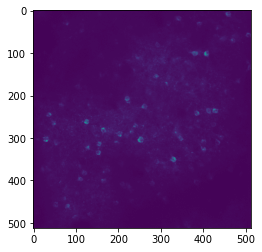

In [22]:
plt.imshow(ctbImgRed)

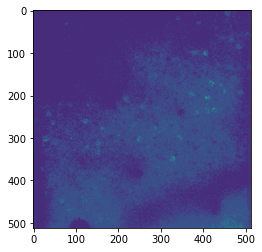

In [6]:
plt.imshow(ctbImgFarRed)

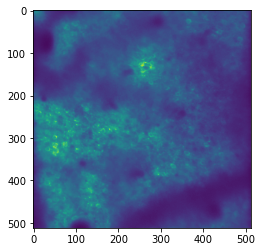

In [7]:
plt.imshow(baselineImg)

In [4]:
baselineImg = (lsens.ProjectionsInfo() & sessionkey & 'ctb_type = "CTB-594"').fetch1('ctb_baseline_800')

In [10]:
def imageNorm(mimg):
    #normalise the image using percentiles (idea of this part came from suite2p code)

    mimg1 = np.percentile(mimg, 1)
    mimg99 = np.percentile(mimg, 99)
    mimg = (mimg - mimg1) / (mimg99 - mimg1)
    mimg = np.maximum(0, np.minimum(1, mimg))

    return mimg    

In [13]:
def circle(med, r):
    """ returns pixels of circle with radius 1.25x radius of cell (r) """
    theta = np.linspace(0.0,2*np.pi,100)
    x = r*1.25 * np.cos(theta) + med[0]
    y = r*1.25 * np.sin(theta) + med[1]
    x = x.astype(np.int32)
    y = y.astype(np.int32)
    return x,y

In [5]:
A = [ 1, 2, 3, 4]
B = [4, 5, 6,  7]

In [8]:
C = [(x,y) for (x,y) in zip(A,B) if (x < 5 and y < 6)]

In [9]:
C

[(1, 4), (2, 5)]

In [13]:
xf = []
yf = []

for p in C:

    xf.append(p[0])
    yf.append(p[1])


In [15]:
yf

[4, 5]

In [11]:
im = imageNorm(baselineImg)

In [4]:
sessionkey = {}
sessionkey['mouse_name'] = 'GF307'
sessionkey['roi_number'] = 0

In [5]:
stats = (lsens.CalciumRois & sessionkey).fetch('roi_stats')
stats = stats[0]

In [6]:
roix = stats['xpix'].flatten()

roiy = stats['ypix'].flatten()

In [18]:
centerX = int((np.abs(np.max(roix)-np.min(roix)))/2 + np.min(roix))
centerY = int((np.abs(np.max(roiy)-np.min(roiy)))/2 + np.min(roiy))

In [19]:
centerY

207

In [17]:
np.min(roix)

222

In [11]:
int((np.abs(np.max(roix)-np.min(roix)))/2)

9

In [9]:
np.max(roiy)

220

In [10]:
roix = stats['xpix'].flatten()

roiy = stats['ypix'].flatten()

{'ypix': array([194, 194, 195, 195, 195, 195, 195, 196, 196, 196, 196, 196, 196,
        196, 196, 196, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197,
        197, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198,
        199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199,
        200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
        200, 200, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
        201, 201, 201, 201, 201, 202, 202, 202, 202, 202, 202, 202, 202,
        202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 203, 203, 203,
        203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203,
        203, 203, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204,
        204, 204, 204, 204, 204, 204, 204, 205, 205, 205, 205, 205, 205,
        205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 206,
        206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206,
        206, 206, 206, 207, 207, 207, 207, 

In [20]:
from matplotlib.colors import hsv_to_rgb
H = np.zeros([512,512])
S = np.zeros([512,512])

H[circ[1], circ[0]] = 0
S[circ[1], circ[0]] = 1


pix = np.concatenate(((H[:, :, np.newaxis]),
                      S[:, :, np.newaxis],
                      im[:, :, np.newaxis]), axis=-1)
pix = hsv_to_rgb(pix)




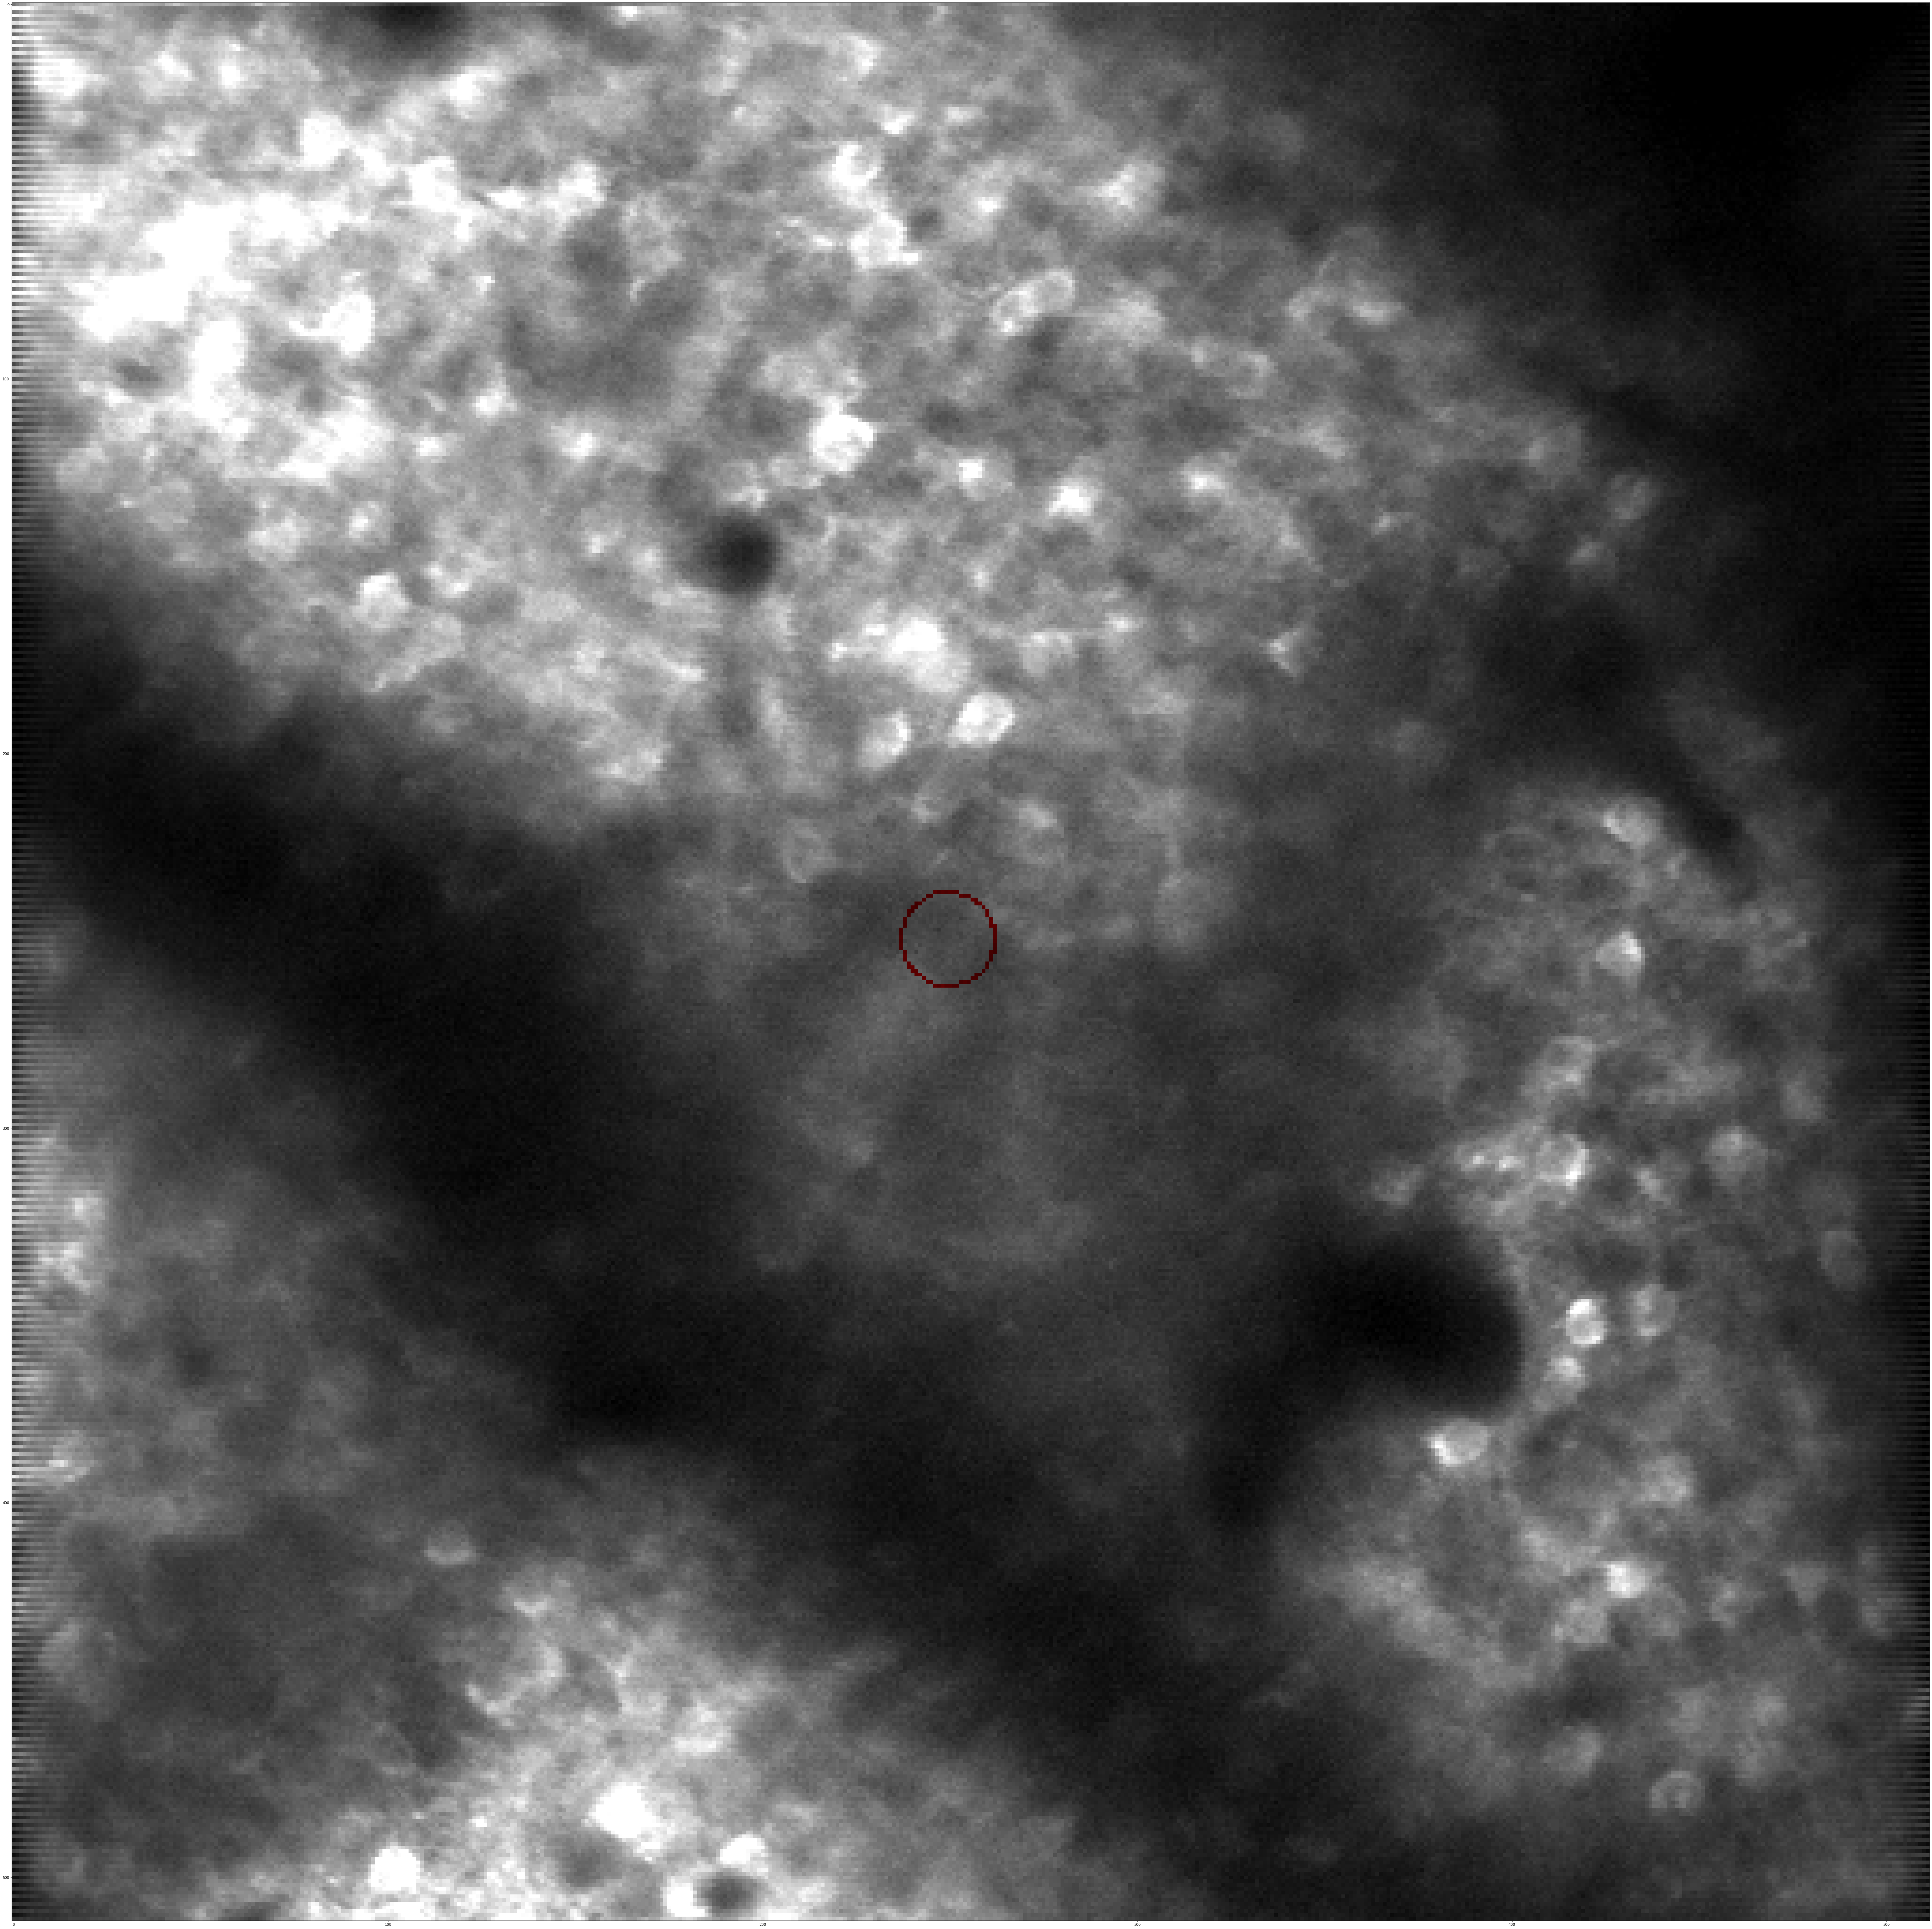

In [24]:
plt.figure(figsize = (100,100))

plt.imshow(pix)

In [16]:
np.min(yRoi)

417

In [17]:
np.max(yRoi)

444

In [18]:
xrange = (lsens.CalciumFOV() & sessionkey).fetch1('xrange')
yrange = (lsens.CalciumFOV() & sessionkey).fetch1('yrange')


In [19]:
xrange

array([ 40, 461])

In [20]:
yrange

array([ 43, 463])

In [6]:
sessionkey = {}
sessionkey['mouse_name'] = 'GF307'

In [7]:
rois =  set((lsens.CalciumRois() & sessionkey).fetch('roi_number'))

In [7]:
theta = np.linspace(0.0,2*np.pi,100)
x = 10*1.25 * np.cos(theta) + 200
y = 10*1.25 * np.sin(theta) + 400

In [11]:
x = x.astype(np.int32)

In [12]:
x

array([212, 212, 212, 212, 212, 211, 211, 211, 210, 210, 210, 209, 209,
       208, 207, 207, 206, 205, 205, 204, 203, 202, 202, 201, 200, 199,
       199, 198, 197, 196, 195, 195, 194, 193, 193, 192, 191, 191, 190,
       190, 189, 189, 188, 188, 188, 188, 187, 187, 187, 187, 187, 187,
       187, 187, 188, 188, 188, 188, 189, 189, 190, 190, 191, 191, 192,
       193, 193, 194, 195, 195, 196, 197, 198, 199, 199, 200, 201, 202,
       202, 203, 204, 205, 205, 206, 207, 207, 208, 209, 209, 210, 210,
       210, 211, 211, 211, 212, 212, 212, 212, 212])

In [ ]:

        baselineImg = (lsens.ProjectionsInfo() & self.sessionkey & 'ctb_type = "CTB-594"').fetch1('ctb_baseline_800')
        ctbImgFarRed =  (lsens.ProjectionsInfo() & self.sessionkey & 'ctb_type = "CTB-647"').fetch1('ctb_image')
        ctbImgRed =  (lsens.ProjectionsInfo() & self.sessionkey & 'ctb_type = "CTB-594 "').fetch1('ctb_image')
        redRegImg =  (lsens.ProjectionsInfo() & self.sessionkey & 'ctb_type = "CTB-594"').fetch1('ctb_redreg')

        suite2pImg = (lsens.CalciumFOV() & self.sessionkey).fetch1('mean_img')
        suite2pImgMax = (lsens.CalciumFOV() & self.sessionkey).fetch1('maxproj_img')
        xrange = (lsens.CalciumFOV() & self.sessionkey).fetch1('xrange')
        yrange = (lsens.CalciumFOV() & self.sessionkey).fetch1('yrange')

        
        # normalise the images using cv2
            
        baselineImgNorm= cv2.normalize(src=baselineImg, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        redRegImgNorm= cv2.normalize(src=redRegImg, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        suite2pImgNorm = cv2.normalize(src=suite2pImg, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        suite2pImgMaxNorm = cv2.normalize(src=suite2pImgMax, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        ctbImgRedNorm =  cv2.normalize(src=ctbImgRed, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        ctbImgFarRedNorm =  cv2.normalize(src=ctbImgFarRed, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
 
        # transform images to SITK formats before registration
        colorImgGreenImgFixed = sitk.GetImageFromArray(suite2pImgNorm)
        colorImgGreenImgMoving  = sitk.GetImageFromArray(baselineImgNorm)

        colorImgRed2Fixed = sitk.GetImageFromArray(redRegImgNorm)
        colorImgRed1Moving= sitk.GetImageFromArray(ctbImgRedNorm)

        colorImgFarRedMoving = sitk.GetImageFromArray(ctbImgFarRedNorm)

        #register the two red images (R1 and R2)
        
        elastixImageFilter = sitk.ElastixImageFilter()
        elastixImageFilter.SetFixedImage(colorImgRed2Fixed)
        elastixImageFilter.SetMovingImage(colorImgRed1Moving)
        elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))
        elastixImageFilter.Execute()

        # get transformed red image and transformation (registering the R1 to R2)
        transformedOnceImgRed1 = elastixImageFilter.GetResultImage()
        transformedOnceImgRed1Array  = sitk.GetArrayFromImage(transformedOnceImgRed1)
        transformParameterMapVector = elastixImageFilter.GetTransformParameterMap()

        #apply this tranformation to the FR image (using the R1 to R2 transformation)
        transformedOnceImgFarRed = sitk.Transformix(colorImgFarRedMoving, transformParameterMapVector)
        transformedOnceImgFarRedArray = sitk.GetArrayFromImage(transformedOnceImgFarRed)

        # register the two green images (suite2p and baseline green image)
        elastixImageFilter = sitk.ElastixImageFilter()
        elastixImageFilter.SetFixedImage(colorImgGreenImgFixed)
        elastixImageFilter.SetMovingImage(colorImgGreenImgMoving)
        elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))
        elastixImageFilter.Execute()
        
        # get transformed green image and transformation matrix
        transformedbaselineImg = elastixImageFilter.GetResultImage()
        transformedbaselineImgArray = sitk.GetArrayFromImage(transformedbaselineImg)
        transformParameterMapVector = elastixImageFilter.GetTransformParameterMap()

        #apply the same transformation to the other colors
        transformedctbImgRed = sitk.Transformix(transformedOnceImgRed1, transformParameterMapVector)
        transformedctbImgRedArray = sitk.GetArrayFromImage(transformedctbImgRed)
        transformedctbImgFarRed = sitk.Transformix(transformedOnceImgFarRed, transformParameterMapVector)
        transformedctbImgFarRedArray = sitk.GetArrayFromImage(transformedctbImgFarRed)

        transformedctbImgRedArrayNorm =  cv2.normalize(src=transformedctbImgRedArray, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        transformedctbImgFarRedArrayNorm =  cv2.normalize(src=transformedctbImgFarRedArray, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
        ImgRed = transformedctbImgRedArrayNorm[yrange[0]:yrange[1],xrange[0]:xrange[1]] 
        ImgFarRed = transformedctbImgRedArrayNorm[yrange[0]:yrange[1],xrange[0]:xrange[1]]
        
        print('Registration done!')

        return (ImgRed,ImgFarRed)